In [3]:
%config Completer.use_jedi = False

In [36]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
#import geoplot as gplt
#import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *

from Problem.PerformanceObserver import *

from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.utils import *
from Problem.Sigma_adapted_functions  import *
from Problem.VRPGini import * 
from Problem.LogDataHandling import *
from Problem.VRPGini import * 
# 2 3 11
fraction_type = "11"
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK25_2"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000
dataset = "fraction_{}".format(fraction_type)
sigma_routes = pd.read_pickle("sigma_data/sigma_solutions.pickle")[int(fraction_type)].to_list()[0]

sigma_starts = [s[0] for s in sigma_routes]
sigma_ends = [s[-1] for s in sigma_routes]

fraction_max_weight = {"2":500,"3":300,"11":1000}

sigma_data = pd.read_csv("sigma_data/data_frac_{}.csv".format(fraction_type))
print(len(sigma_data))
pickups = sigma_data.where(sigma_data.Type ==1).dropna()
dropoffs = sigma_data.where(sigma_data.Type >1).dropna()
terminals = sigma_data.where(sigma_data.Type == 3).dropna()
sigma_demands_DF = separate_large_demands(sigma_data,fraction_max_weight[fraction_type],sigma_starts)
sigma_demands = sigma_demands_DF.Demand.astype(float).to_numpy()
sigma_station_data = sigma_demands_DF.rename(columns={"Demand":"Demand(kg)"})#pd.DataFrame(data=sigma_demands,columns=["Demand(kg)"])
meta_data["Customer Amount"] = len(sigma_data)
sigma_lat = sigma_data.Lat.to_numpy()
sigma_long = sigma_data.Long.to_numpy()
sigma_coordinates = np.array([sigma_lat,sigma_long]).T


sigma_distance_matrix,sigma_time_matrix = load_saved_here_data("sigma_data/","sigma_{}".format(fraction_type))#
sigma_distance_matrix = sigma_distance_matrix.to_numpy()
sigma_time_matrix = sigma_time_matrix.to_numpy()

35


In [37]:
pickups_2 = sigma_demands_DF.where(sigma_demands_DF.Demand > 0).dropna()
print(len(terminals) + len(dropoffs) + len(pickups_2))

43


In [38]:
sigma_routing_context = RoutingContext(distance_matrix=sigma_distance_matrix,time_matrix=sigma_time_matrix,station_coordinates=sigma_coordinates,station_data=sigma_station_data,meta_data=meta_data)

In [39]:
startNodeIndeces = sigma_starts + terminals.index.to_list()
endNodeIndeces = sigma_ends + dropoffs.index.to_list() 
locationNodeIndeces = pickups_2.index.to_list()

# vehicleData = {"emptyWeights":[3000],"maxLoads":[3650],"fuelEmpty":[12],"fuelFull":[15]}
vehicleData = {"emptyWeights":[3000,5500],"maxLoads":[3650,8500],"fuelEmpty":[12,22.5],"fuelFull":[15,27.5]}

vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,heterogeneousFleet=True)

customer_demands = sigma_station_data.T.loc["Demand(kg)"].astype(int).to_numpy()

initial_solution = cheapest_insertion_dict2(locationNodeIndeces,vehicles,endNodeIndeces,sigma_routing_context)




In [40]:
results = []


for fraction_type in ["2","3","11"]:

    #fraction_type = "2"
    # https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
    api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

    dataset = "UK25_2"
    meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

    meta_data["F-C Empty (l/100km)"] = 12.5
    meta_data["F-C Full (l/100km)"] = 15
    meta_data["Vehicle Weight"] = 3000
    dataset = "fraction_{}".format(fraction_type)
    sigma_routes = pd.read_pickle("sigma_data/sigma_solutions.pickle")[int(fraction_type)].to_list()[0]

    sigma_starts = [s[0] for s in sigma_routes]
    sigma_ends = [s[-1] for s in sigma_routes]

    fraction_max_weight = {"2":500,"3":300,"11":1000}

    sigma_data = pd.read_csv("sigma_data/data_frac_{}.csv".format(fraction_type))
    print(len(sigma_data))
    pickups = sigma_data.where(sigma_data.Type ==1).dropna()
    dropoffs = sigma_data.where(sigma_data.Type >1).dropna()
    terminals = sigma_data.where(sigma_data.Type == 3).dropna()
    sigma_demands_DF = separate_large_demands(sigma_data,fraction_max_weight[fraction_type],sigma_starts)
    sigma_demands = sigma_demands_DF.Demand.astype(float).to_numpy()
    sigma_station_data = sigma_demands_DF.rename(columns={"Demand":"Demand(kg)"})#pd.DataFrame(data=sigma_demands,columns=["Demand(kg)"])
    meta_data["Customer Amount"] = len(sigma_data)
    sigma_lat = sigma_data.Lat.to_numpy()
    sigma_long = sigma_data.Long.to_numpy()
    sigma_coordinates = np.array([sigma_lat,sigma_long]).T


    sigma_distance_matrix,sigma_time_matrix = load_saved_here_data("sigma_data/","sigma_{}".format(fraction_type))#
    sigma_distance_matrix = sigma_distance_matrix.to_numpy()
    sigma_time_matrix = sigma_time_matrix.to_numpy()
    pickups_2 = sigma_demands_DF.where(sigma_demands_DF.Demand > 0).dropna()
    sigma_routing_context = RoutingContext(distance_matrix=sigma_distance_matrix,time_matrix=sigma_time_matrix,station_coordinates=sigma_coordinates,station_data=sigma_station_data,meta_data=meta_data)



    startNodeIndeces = sigma_starts + terminals.index.to_list()
    endNodeIndeces = sigma_ends + dropoffs.index.to_list() 
    locationNodeIndeces = pickups_2.index.to_list()

    vehicleData = {"emptyWeights":[3000],"maxLoads":[3650],"fuelEmpty":[12],"fuelFull":[15]}
    vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData)

    customer_demands = sigma_station_data.T.loc["Demand(kg)"].astype(int).to_numpy()

    initial_solution = cheapest_insertion_dict2(locationNodeIndeces,vehicles,endNodeIndeces,sigma_routing_context,set_nearest_ends=True)
    initial_path = get_numerical_path(initial_solution["paths"],vehicles)
    
    results.append(get_solution_results2(solutions_SA,routing_context=sigma_routing_context,vehicles=vehicles,paths_to_use=initial_path))
    


77


NameError: name 'solutions_SA' is not defined

In [18]:
# initial_solutions = pd.read_pickle("sigma_data/initial_solutions.pickle")

# results = []
# for fraction_type ,solution_key in zip(["2","3","11"],initial_solutions):
    
#     solution = initial_solutions[solution_key].to_list()[0]
    
    
#     dataset = "UK25_2"
#     meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

#     meta_data["F-C Empty (l/100km)"] = 12.5
#     meta_data["F-C Full (l/100km)"] = 15
#     meta_data["Vehicle Weight"] = 3000
#     dataset = "fraction_{}".format(fraction_type)
#     sigma_routes = pd.read_pickle("sigma_data/sigma_solutions.pickle")[int(fraction_type)].to_list()[0]

#     sigma_starts = [s[0] for s in sigma_routes]
#     sigma_ends = [s[-1] for s in sigma_routes]

#     fraction_max_weight = {"2":500,"3":300,"11":1000}

#     sigma_data = pd.read_csv("sigma_data/data_frac_{}.csv".format(fraction_type))

#     pickups = sigma_data.where(sigma_data.Type ==1).dropna()
#     dropoffs = sigma_data.where(sigma_data.Type >1).dropna()
#     terminals = sigma_data.where(sigma_data.Type == 3).dropna()
#     sigma_demands_DF = separate_large_demands(sigma_data,fraction_max_weight[fraction_type],sigma_starts)
#     sigma_demands = sigma_demands_DF.Demand.astype(float).to_numpy()
#     sigma_station_data = sigma_demands_DF.rename(columns={"Demand":"Demand(kg)"})#pd.DataFrame(data=sigma_demands,columns=["Demand(kg)"])
#     meta_data["Customer Amount"] = len(sigma_data)
#     sigma_lat = sigma_data.Lat.to_numpy()
#     sigma_long = sigma_data.Long.to_numpy()
#     sigma_coordinates = np.array([sigma_lat,sigma_long]).T


#     sigma_distance_matrix,sigma_time_matrix = load_saved_here_data("sigma_data/","sigma_{}".format(fraction_type))#
#     sigma_distance_matrix = sigma_distance_matrix.to_numpy()
#     sigma_time_matrix = sigma_time_matrix.to_numpy()
#     pickups_2 = sigma_demands_DF.where(sigma_demands_DF.Demand > 0).dropna()
#     sigma_routing_context = RoutingContext(distance_matrix=sigma_distance_matrix,time_matrix=sigma_time_matrix,station_coordinates=sigma_coordinates,station_data=sigma_station_data,meta_data=meta_data)



#     startNodeIndeces = sigma_starts + terminals.index.to_list()
#     endNodeIndeces = sigma_ends + dropoffs.index.to_list() 
#     locationNodeIndeces = pickups_2.index.to_list()

#     vehicleData = {"emptyWeights":[3000],"maxLoads":[3650],"fuelEmpty":[12],"fuelFull":[15]}
#     vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData)

#     customer_demands = sigma_station_data.T.loc["Demand(kg)"].astype(int).to_numpy()

    
#     results.append(get_solution_results2(best_sol,routing_context=sigma_routing_context,vehicles=vehicles,paths_to_use=solution))
    


In [6]:
from datetime import timedelta
def time_string_to_minutes(time_string):
    """
    https://stackoverflow.com/a/60638687/12463908
    """
    
    h =time_string
    delta = timedelta(hours=int(h.split(':')[0]), minutes=int(h.split(':')[1]), seconds=int(h.split(':')[2]))
    minutes = delta.total_seconds()/(60**2)
    return minutes


In [8]:
sigma_2 = results[0]
sigma_3 = results[1]
sigma_11 = results[2]
sigma_2["Total Travel Time (h)"] = sigma_2["Total Travel Time (h)"].apply(time_string_to_minutes)
sigma_3["Total Travel Time (h)"] = sigma_3["Total Travel Time (h)"].apply(time_string_to_minutes)
sigma_11["Total Travel Time (h)"] =  sigma_11["Total Travel Time (h)"].apply(time_string_to_minutes)




NameError: name 'results' is not defined

In [ ]:
sigma_2

In [ ]:
sigma_2["vehicle_route_time"] = [[x for x in sigma_2["Total Travel Time (h)"].to_list()]]*len(sigma_2)
sigma_3["vehicle_route_time"] = [[x for x in sigma_3["Total Travel Time (h)"].to_list()]]*len(sigma_3)
sigma_11["vehicle_route_time"] =  [[x for x in sigma_11["Total Travel Time (h)"].to_list()]]*len(sigma_11)

sigma_2_sum = sigma_2[["Total Travel Time (h)","Fuel Consumption (L)", "Total distance (km)"]].sum()
sigma_3_sum = sigma_3[["Total Travel Time (h)","Fuel Consumption (L)", "Total distance (km)"]].sum()
sigma_11_sum = sigma_11[["Total Travel Time (h)","Fuel Consumption (L)", "Total distance (km)"]].sum()


sigma_2_sum["Vehicle Amount"] = len(sigma_2.where(sigma_2["Total distance (km)"] > 0 ).dropna(how="all"))
sigma_3_sum["Vehicle Amount"] = len(sigma_3.where(sigma_3["Total distance (km)"] > 0 ).dropna(how="all"))
sigma_11_sum["Vehicle Amount"] = len(sigma_11.where(sigma_11["Total distance (km)"] > 0 ).dropna(how="all"))


sigma_2_sum["Gini Index"] = get_gini_coefficients(sigma_2)[0]
sigma_3_sum["Gini Index"] = get_gini_coefficients(sigma_3)[0]
sigma_11_sum["Gini Index"] = get_gini_coefficients(sigma_11)[0]




In [ ]:
combined_res = pd.DataFrame(pd.concat([sigma_2_sum,sigma_3_sum,sigma_11_sum],axis=1))
combined_res.columns =["Dataset 1", "Dataset 2", "Dataset 3"]
combined_res = combined_res.round(2)
print(combined_res.to_latex())

In [ ]:
sigma_2[["Total distance (km)","Total Travel Time (h)","Fuel Consumption (L)"]].sum()

In [40]:
cost_function_dict = {"distance_matrix":sigma_distance_matrix,"time_matrix":sigma_time_matrix,
                              "demands":customer_demands,"vehicle_weight":3000,"start_positions":startNodeIndeces,"meta_data":meta_data}

min_allowed_drivetime_hours = 0
data_model_input_multi_objective = {'routing_context':sigma_routing_context,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':3,'objective_labels':['Total Fuel','Total Drive Time'],
                                    'constraint_amount':6,'number_of_cities':len(initial_solution),
                                   'min_drivetime':min_allowed_drivetime_hours}

data_model_input_single_objective = {'routing_context':sigma_routing_context,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':2,'objective_labels':['Total Fuel',"Time"],
                                    'constraint_amount':6,'number_of_cities':len(initial_solution),
                                    'min_drivetime':min_allowed_drivetime_hours}


plot_data_storage_base = {'fitness':[], 'route_distance':[],'fuel_consumption':[],'vehicle_loads':[],'computation_times':[],'vehicle_route_time':[],'violation':[],'paths':[],'distance_to_origin':[]}
logpath = "parameter_data/heterogeneous/bi_obj/{}".format(dataset)
try: 
    os.mkdir(logpath) 
except OSError as error: 
    print(error) 

amount_of_runs = 10
amount_of_evaluations = 10000
observer_update_interval = 60
optimal_parameters = {"SA":{"mutation":0.9}, "GA":{"mutation":0.9,"crossover":0.25,"population_size":30},
                     "NSGAII":{"mutation":0.7,"crossover":0.50,"population_size":30},
                     "NSGAIII":{"mutation":0.9,"crossover":0.75,"population_size":30},
                     "UNSGAIII":{"mutation":0.9,"crossover":0.75,"population_size":30},
                     "IBEA":{"mutation":0.7,"crossover":0.75,"population_size":30}}
optimal_parameters = {"SA":{"mutation":0.9}, "GA":{"mutation":0.9,"crossover":0.25,"population_size":30},
                     "NSGAII":{"mutation":0.9,"crossover":0.50,"population_size":30},
                     "NSGAIII":{"mutation":0.9,"crossover":0.50,"population_size":20},
                     "UNSGAIII":{"mutation":0.9,"crossover":0.25,"population_size":20},
                     "IBEA":{"mutation":0.9,"crossover":0.75,"population_size":20}}
            

In [13]:
from jmetal.algorithm.singleobjective import SimulatedAnnealing
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation,SimpleRandomMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.comparator import DominanceComparator
from datetime import datetime

parameters_SA = optimal_parameters["SA"]

plot_data_SA = deepcopy(plot_data_storage_base)
for x in range(1):
    problem_SA = VRP2(data_model_input_single_objective)
    problem_SA.name = "SA"
    problem_SA.assignClosestEndPoint = True
    max_evaluations = 5000

    algorithm_SA = SimulatedAnnealing(problem=problem_SA,
                                   mutation=PermutationSwapMutation(parameters_SA["mutation"]),
                                   termination_criterion=StoppingByEvaluations(max_evaluations))

    performance_observer_SA = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_SA])
    performance_observer_SA.maxEpochs=  amount_of_runs
    performance_observer_SA.currentEpoch = x

    algorithm_SA.observable.register(observer=performance_observer_SA)
    algorithm_SA.run() 

    solutions_SA = algorithm_SA.get_result()        
    store_plot_data(plot_data_SA,performance_observer_SA,solutions_SA)
sa_numerical_path = get_numerical_path(solutions_SA.path,vehicles)


Epoch:1 of 10
Evaluations: 4980/5000
Params: {'mutation': 0.9}
Best fitness: 1462.1835                          
Best total fuel consumption:1191.85 
Best total drive time:6647.08                          
Computing time: 74.57s
Average computing speed: 66.78it/s                          
Current Route:[['V0', 136, 213, 290, 367, 444, 521, 906, 60], ['V1', 106, 183, 491, 337, 414, 799, 568, 63], ['V2', 722, 645, 1030, 876, 953, 260, 1107, 63], ['V3', 88, 165, 242, 319, 396, 473, 550, 63], ['V4', 97, 174, 251, 328, 405, 482, 559, 713, 0], ['V5', 131, 208, 285, 362, 439, 593, 516, 66], ['V6', 316, 162, 701, 85, 393, 470, 547, 239, 64], ['V7', 132, 209, 286, 671, 440, 517, 594, 748, 72], ['V8', 338, 107, 184, 261, 415, 492, 569, 63], ['V9', 105, 182, 259, 336, 798, 490, 567, 413, 63], ['V10', 111, 188, 265, 342, 419, 496, 573, 64], ['V11', 589, 512, 281, 358, 435, 204, 127, 72], ['V12', 100, 177, 254, 331, 408, 485, 562, 60], ['V13', 108, 185, 262, 878, 416, 493, 570, 1032, 63], ['V14', 1

In [10]:
pd.DataFrame(plot_data_SA).to_csv("{}/SA.csv".format(logpath))

In [10]:
from jmetal.algorithm.singleobjective import GeneticAlgorithm
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.selection import Selection
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.observer import ProgressBarObserver, VisualizerObserver,PrintObjectivesObserver,BasicObserver
from jmetal.util.evaluator import MultiprocessEvaluator
from datetime import datetime


parameters_GA = optimal_parameters["GA"]



plot_data_GA = deepcopy(plot_data_storage_base)
for x in range(1):
    problem_GA = VRP2(data_model_input_single_objective)
    problem_GA.name = "GA"
    problem_GA.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_GA = GeneticAlgorithm(problem=problem_GA,
                    population_size=parameters_GA["population_size"],
                    offspring_population_size=parameters_GA["population_size"],
                    mutation=PermutationSwapMutation(parameters_GA["mutation"]),
                    crossover=PMXCrossover(parameters_GA["crossover"]),
                    selection=BestSolutionSelection(),
                    termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
                    ,population_evaluator=MultiprocessEvaluator()
                    )


    performance_observer_GA = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_GA])
    performance_observer_GA.maxEpochs= amount_of_runs
    performance_observer_GA.currentEpoch = x
    algorithm_GA.observable.register(observer=performance_observer_GA)
    
    start_time = datetime.now() 
    algorithm_GA.run()
    run_time = datetime.now() - start_time
    solutions_GA = algorithm_GA.get_result()


    store_plot_data(plot_data_GA,performance_observer_GA,solutions_GA)
    

Epoch:1 of 10
Evaluations: 10020/10000
Params: {'mutation': 0.9, 'crossover': 0.25, 'population_size': 30}
Best fitness: 1488.8924                          
Best total fuel consumption:1196.04 
Best total drive time:6727.88                          
Computing time: 56.58s
Average computing speed: 177.08it/s                          
Current Route:[['V0', 213, 136, 444, 521, 598, 367, 290, 60], ['V1', 337, 260, 106, 491, 183, 414, 568, 63], ['V2', 799, 722, 1030, 876, 645, 953, 1107, 63], ['V3', 242, 473, 88, 165, 550, 319, 396, 63], ['V4', 405, 174, 251, 482, 97, 713, 559, 328, 0], ['V5', 593, 439, 208, 362, 285, 131, 516, 66], ['V6', 470, 393, 239, 547, 701, 162, 316, 85, 64], ['V7', 209, 440, 517, 363, 132, 594, 748, 286, 72], ['V8', 492, 338, 184, 261, 569, 415, 107, 63], ['V9', 259, 413, 105, 798, 182, 490, 336, 567, 63], ['V10', 342, 111, 496, 573, 188, 419, 265, 64], ['V11', 281, 512, 435, 127, 204, 589, 358, 72], ['V12', 177, 562, 408, 100, 485, 254, 331, 60], ['V13', 416, 339, 

In [12]:
pd.DataFrame(plot_data_GA).to_csv("{}/GA.csv".format(logpath))

In [58]:
hash(tuple([1,2,3]))

-5685243413837761780

In [15]:
str([1,2,3])

'[1, 2, 3]'

In [41]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAII, UniformReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameters_NSGAII = optimal_parameters["NSGAII"]

plot_data_NSGAII = deepcopy(plot_data_storage_base)
for x in range(10):
    problem_NSGAII = VRP2(data_model_input_single_objective)
    problem_NSGAII.name = "NSGA-II"
    problem_NSGAII.assignClosestEndPoint = True
    max_evaluations = 10000

    algorithm_NSGAII = NSGAII(problem=problem_NSGAII,
                            population_size=parameters_NSGAII["population_size"],
                            offspring_population_size=parameters_NSGAII["population_size"],
                            mutation=PermutationSwapMutation(parameters_NSGAII["mutation"]),
                            crossover=PMXCrossover(parameters_NSGAII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations),
                            population_evaluator=MultiprocessEvaluator()

                               )

    performance_observer_NSGAII = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_NSGAII])
    performance_observer_NSGAII.maxEpochs= amount_of_runs
    performance_observer_NSGAII.currentEpoch = x



    algorithm_NSGAII.observable.register(observer=performance_observer_NSGAII)
    algorithm_NSGAII.run()

    solutions_NSGAII = algorithm_NSGAII.get_result()
    front_NSGAII = get_non_dominated_solutions(solutions_NSGAII)
    
    best_sol = sorted(get_non_dominated_solutions(solutions_NSGAII),key=lambda solution:np.sum(solution.objectives))[0]
    
    
    store_plot_data(plot_data_NSGAII,performance_observer_NSGAII,best_sol)




Epoch:10 of 10
Evaluations: 10020/10000
Params: {'mutation': 0.9, 'crossover': 0.5, 'population_size': 30}
Best fitness: 203.1962 --- 184.55                        
Best total fuel consumption:203.2 
Computing time: 11.75s                        
Average computing speed: 853.06it/s
Current Route:[['V0', 50, 85, 30], ['V2', 49, 30], ['V4', 61, 96, 31], ['V6', 42, 6, 28, 27, 5, 31], ['V10', 23, 59, 25, 13, 34], ['V12', 17, 11, 20, 21, 12, 34], ['V13', 22, 64, 99, 34], ['V14', 51, 34], ['V17', 45, 32], ['V19', 44, 32], ['V20', 36, 0, 32], ['V23', 43, 19], ['V25', 39, 74, 38, 31], ['V26', 37, 18]]
Flags: []                        
Violation:0
Vehicle amount:14


In [42]:
gini_coefficient(best_sol.vehicle_route_times)

0.2987201423069096

In [43]:
nsga2_log_data = pd.DataFrame(plot_data_NSGAII)
nsga2_log_data.to_csv("{}/NSGA2.csv".format(logpath))

In [44]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameters_NSGAIII = optimal_parameters["NSGAIII"]


plot_data_NSGAIII = deepcopy(plot_data_storage_base)

for x in range(10):

    problem_NSGAIII = VRP2(data_model_input_single_objective)
    problem_NSGAIII.name = "NSGA-III"
    problem_NSGAIII.assignClosestEndPoint = True
    max_evaluations = 10000

    algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                            population_size=parameters_NSGAIII["population_size"],
                            reference_directions=UniformReferenceDirectionFactory(2, n_partitions=8),
                            mutation= PermutationSwapMutation(parameters_NSGAIII["mutation"]),
                            crossover=PMXCrossover(parameters_NSGAIII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations)
                            ,population_evaluator=MultiprocessEvaluator()
                               )
    performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_NSGAIII])
    performance_observer_NSGAIII.maxEpochs=  amount_of_runs
    performance_observer_NSGAIII.currentEpoch =  x
    algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
    algorithm_NSGAIII.run()

    solutions_NSGAIII = algorithm_NSGAIII.get_result()
    front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)
    best_sol = sorted(get_non_dominated_solutions(solutions_NSGAIII),key=lambda solution:np.sum(solution.objectives))[0]
    store_plot_data(plot_data_NSGAIII,performance_observer_NSGAIII,best_sol)



nsga3_numerical_path = get_numerical_path(front_NSGAIII[0].path,vehicles)


Epoch:10 of 10
Evaluations: 9960/10000
Params: {'mutation': 0.9, 'crossover': 0.5, 'population_size': 20}
Best fitness: 209.5001 --- 184.55                        
Best total fuel consumption:209.5 
Computing time: 12.39s                        
Average computing speed: 803.81it/s
Current Route:[['V0', 50, 85, 30], ['V2', 49, 30], ['V4', 96, 61, 31], ['V6', 42, 6, 28, 27, 5, 31], ['V8', 38, 31], ['V11', 23, 59, 25, 17, 34], ['V10', 13, 11, 20, 21, 12, 34], ['V12', 22, 64, 99, 34], ['V14', 51, 34], ['V16', 45, 32], ['V18', 44, 32], ['V20', 36, 0, 32], ['V22', 43, 19], ['V24', 39, 74, 33], ['V26', 37, 18]]
Flags: []                        
Violation:0
Vehicle amount:15


In [45]:
nsga3_log_data = pd.DataFrame(plot_data_NSGAIII)
nsga3_log_data.to_csv("{}/NSGA3.csv".format(logpath))

In [46]:
nsga3_result = get_solution_results2(front_NSGAIII[0],routing_context=sigma_routing_context,vehicles=vehicles)#["Fuel Consumption (L)"].sum()
nsga3_result

,Total distance (km),Total Travel Time (h),Total load (kg),Fuel Consumption (L),Avg Fuel Conspumtion (L/100km),Avg Speed (km/h)
0,52.024,00:56:10,1045.0,7.580786,14.571709,55.574599
1,109.253,01:26:19,441.0,18.491815,16.925682,75.943387
2,190.526,02:35:09,1492.0,31.906908,16.746747,73.680696
3,196.165,02:30:32,444.0,33.831642,17.246523,78.187998
4,160.428,02:31:53,1717.0,28.547419,17.794537,63.375486
5,122.146,01:47:09,466.0,19.093562,15.631754,68.397200
6,63.101,01:26:43,1988.0,10.464699,16.584046,43.660119
7,109.424,02:31:41,1690.0,15.896345,14.527293,43.283859
8,53.963,01:24:07,2200.0,9.223214,17.091737,38.491540
9,56.047,00:52:53,444.0,8.377873,14.947943,63.589411


In [47]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameters_UNSGAIII = optimal_parameters["UNSGAIII"]

plot_data_UNSGAIII = deepcopy(plot_data_storage_base)
for x in range(10):

    problem_UNSGAIII = VRP2(data_model_input_single_objective)
    problem_UNSGAIII.name = "NSGA-III"
    problem_UNSGAIII.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_UNSGAIII = UNSGAIII(problem=problem_UNSGAIII,
                            population_size=parameters_UNSGAIII["population_size"],
                            reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                            mutation= PermutationSwapMutation(parameters_UNSGAIII["mutation"]),
                            crossover=PMXCrossover(parameters_UNSGAIII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations)
                            ,population_evaluator=MultiprocessEvaluator()
                               )
    performance_observer_UNSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_UNSGAIII])
    performance_observer_UNSGAIII.maxEpochs= amount_of_runs
    performance_observer_UNSGAIII.currentEpoch =  x

    algorithm_UNSGAIII.observable.register(observer=performance_observer_UNSGAIII)
    algorithm_UNSGAIII.run()

    solutions_UNSGAIII = algorithm_UNSGAIII.get_result()
    front_UNSGAIII = get_non_dominated_solutions(solutions_UNSGAIII)
    best_sol = sorted(get_non_dominated_solutions(solutions_UNSGAIII),key=lambda solution:np.sum(solution.objectives))[0]
    store_plot_data(plot_data_UNSGAIII,performance_observer_UNSGAIII,best_sol)

     
Unsga3_numerical_path = get_numerical_path(front_UNSGAIII[0].path,vehicles)

Epoch:10 of 10
Evaluations: 9960/10000
Params: {'mutation': 0.9, 'crossover': 0.25, 'population_size': 20}
Best fitness: 205.807 --- 184.55                        
Best total fuel consumption:205.81 
Computing time: 12.13s                        
Average computing speed: 821.0it/s
Current Route:[['V0', 50, 85, 30], ['V2', 49, 30], ['V4', 61, 96, 31], ['V6', 42, 6, 28, 27, 5, 31], ['V10', 23, 59, 25, 13, 34], ['V12', 17, 11, 20, 21, 12, 34], ['V13', 22, 64, 99, 34], ['V15', 51, 34], ['V17', 45, 32], ['V19', 44, 32], ['V21', 36, 0, 32], ['V22', 43, 19], ['V25', 74, 39, 38, 31], ['V26', 37, 18]]
Flags: []                        
Violation:0
Vehicle amount:14


In [48]:
unsga3_log_data = pd.DataFrame(plot_data_UNSGAIII)
unsga3_log_data.to_csv("{}/UNSGA3.csv".format(logpath))

In [49]:
from jmetal.algorithm.multiobjective.ibea import IBEA
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameters_IBEA = optimal_parameters["IBEA"]

plot_data_IBEA = deepcopy(plot_data_storage_base)
for x in range(10):
    problem_IBEA = VRP2(data_model_input_single_objective)
    problem_IBEA.name = "IBEA"
    problem_IBEA.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_IBEA = IBEA(problem=problem_IBEA,
                            population_size=parameters_IBEA["population_size"],
                            offspring_population_size=parameters_IBEA["population_size"],
                            kappa =1,
                            mutation=PermutationSwapMutation(parameters_IBEA["mutation"]),
                            crossover=PMXCrossover(parameters_IBEA["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations),
                            population_evaluator=MultiprocessEvaluator(),
                               )

    performance_observer_IBEA = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_IBEA])
    performance_observer_IBEA.maxEpochs= amount_of_runs
    performance_observer_IBEA.currentEpoch =  x


    algorithm_IBEA.observable.register(observer=performance_observer_IBEA)
    algorithm_IBEA.run()

    solutions_IBEA = algorithm_IBEA.get_result()
    front_IBEA = get_non_dominated_solutions(solutions_IBEA)
    best_sol = sorted(get_non_dominated_solutions(solutions_IBEA),key=lambda solution:np.sum(solution.objectives))[0]
    
    
    store_plot_data(plot_data_IBEA,performance_observer_IBEA,best_sol)

ibea_numerical_path = get_numerical_path(front_IBEA[0].path,vehicles)

Epoch:10 of 10
Evaluations: 9960/10000
Params: {'mutation': 0.9, 'crossover': 0.75, 'population_size': 20}
Best fitness: 198.0843 --- 184.55                        
Best total fuel consumption:198.08 
Computing time: 15.31s                        
Average computing speed: 650.42it/s
Current Route:[['V0', 50, 85, 30], ['V2', 49, 30], ['V4', 61, 96, 31], ['V6', 42, 6, 28, 27, 5, 31], ['V11', 23, 59, 25, 13, 34], ['V10', 17, 11, 20, 21, 12, 34], ['V12', 99, 64, 22, 34], ['V14', 51, 34], ['V16', 45, 32], ['V18', 44, 32], ['V20', 36, 0, 32], ['V22', 43, 19], ['V24', 39, 74, 38, 31], ['V27', 37, 18]]
Flags: []                        
Violation:0
Vehicle amount:14


In [50]:
logpath

'parameter_data/heterogeneous/bi_obj/fraction_11'

In [51]:
ibea_log_data = pd.DataFrame(plot_data_IBEA)
ibea_log_data.to_csv("{}/IBEA.csv".format(logpath))

In [62]:
abs(sum(best_sol.constraints))

1929

In [63]:
def plot_vehicle_drivetimes(dataframe,parameter_group):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)
    
    dataframe_parameter_group = dataframe.where(dataframe["Parameter Group"] == parameter_group).dropna()
    
    if type(dataframe_parameter_group.vehicle_route_time.iloc[0]) == str:
        dataframe_parameter_group.vehicle_route_time = dataframe_parameter_group.vehicle_route_time.apply(literal_eval)
        
    dataframe_parameter_group["vehicle_amount"] = dataframe_parameter_group.vehicle_route_time.apply(lambda x: len(x))
    
    vehicle_amounts = sorted(dataframe_parameter_group.vehicle_amount.unique())
    num_bars = len(vehicle_amounts)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)
    
    for vehicle_amount,offset in zip(vehicle_amounts,offsets):
        vehicle_amount_df = dataframe_parameter_group.where(dataframe_parameter_group.vehicle_amount == vehicle_amount).dropna()
        
        vehicle_amount_route_times = np.stack(vehicle_amount_df.vehicle_route_time.apply(lambda x: np.sort(x)[::-1]/60).to_numpy())
        vehicle_route_times_mean = np.mean(vehicle_amount_route_times,axis=0)
        plt.bar(np.arange(vehicle_amount) + offset,vehicle_route_times_mean,width=0.2,alpha=0.5,label=r"$\bf{%s}\ Vehicles$" % (vehicle_amount))
    
    plt.ylabel("Drivetime (minutes)")
    plt.xlabel("Vehicles")
    
    plt.legend(bbox_to_anchor=(1,1))
        
    
    

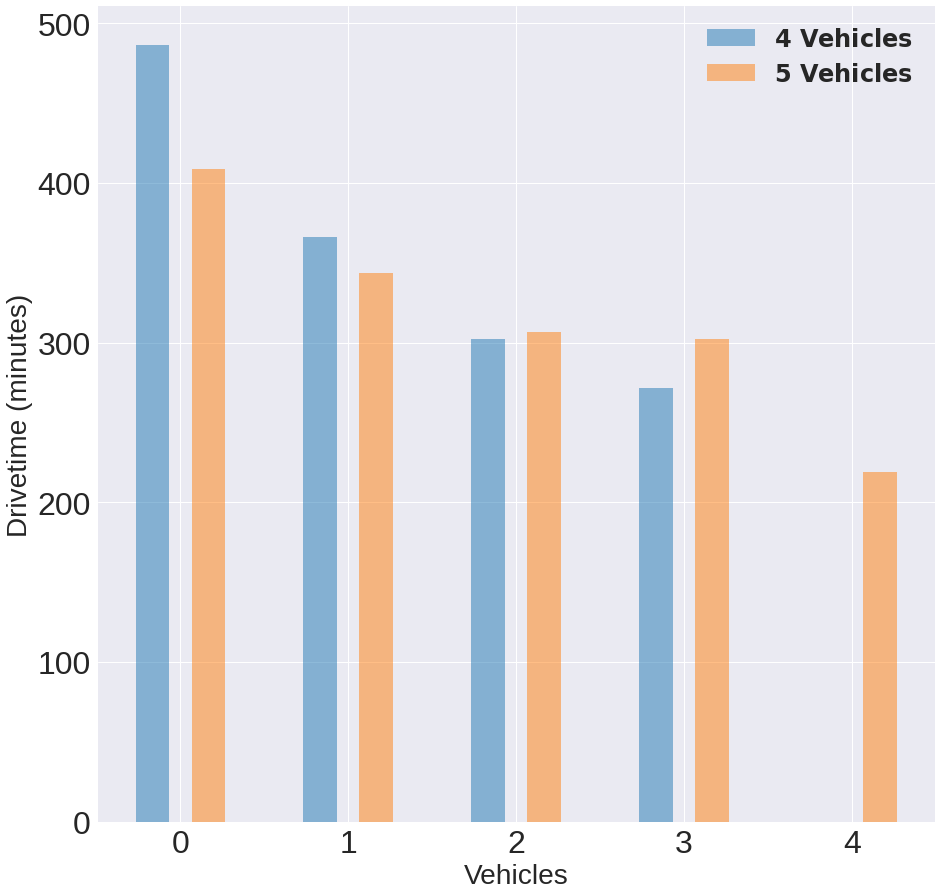

In [64]:
df = pd.DataFrame(plot_data_IBEA)
df["Parameter Group"] = 1

plot_vehicle_drivetimes(df,1)

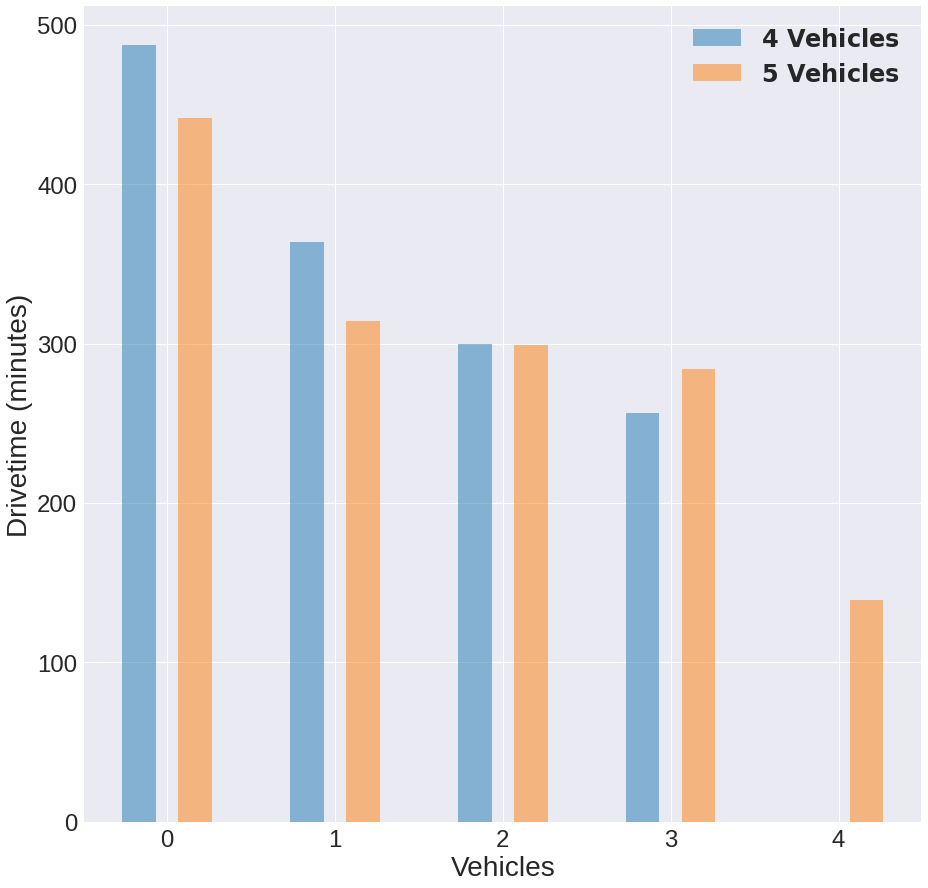

In [20]:
df = pd.DataFrame(plot_data_IBEA)
df["Parameter Group"] = 1

plot_vehicle_drivetimes(df,1)

In [21]:
df.fuel_consumption

0    [229.79056568783835, 229.79056568783835, 229.7...
1    [229.79056568783835, 229.79056568783835, 229.7...
2    [229.79056568783835, 229.79056568783835, 229.7...
3    [229.79056568783835, 233.45665278304295, 268.2...
4    [229.79056568783835, 317.75746352856254, 317.7...
5    [229.79056568783835, 229.79056568783835, 229.7...
6    [229.79056568783835, 229.79056568783835, 229.7...
7    [266.6245700865283, 266.6245700865283, 266.624...
8    [229.79056568783835, 229.79056568783835, 229.7...
9    [229.79056568783835, 229.79056568783835, 229.3...
Name: fuel_consumption, dtype: object

In [12]:
500/60

8.333333333333334

In [27]:
ibea_result

,Total distance (km),Total Travel Time (h),Total load (kg),Fuel Consumption (L),Avg Fuel Conspumtion (L/100km),Avg Speed (km/h)
0,95.468,01:56:46,1499.0,14.413951,15.098201,49.055781
1,109.253,01:26:19,441.0,18.491815,16.925682,75.943387
2,24.655,00:25:59,1362.0,3.670830,14.888786,56.932649
3,212.087,03:04:33,2291.0,36.777498,17.340760,68.952696
4,122.146,01:47:09,466.0,19.093562,15.631754,68.397200
5,122.057,02:40:26,3635.0,18.900407,15.484902,45.647746
6,117.449,02:18:40,1789.0,17.020256,14.491615,50.819279
7,194.620,02:44:17,803.0,31.547208,16.209643,71.079639
8,83.985,01:17:09,313.0,12.667505,15.083056,65.315619
9,146.599,02:15:48,871.0,22.840993,15.580593,64.771281


In [26]:
ibea_result = get_solution_results2(best_sol,routing_context=sigma_routing_context,vehicles=vehicles)
ibea_result

,Total distance (km),Total Travel Time (h),Total load (kg),Fuel Consumption (L),Avg Fuel Conspumtion (L/100km),Avg Speed (km/h)
0,95.468,01:56:46,1499.0,14.413951,15.098201,49.055781
1,109.253,01:26:19,441.0,18.491815,16.925682,75.943387
2,24.655,00:25:59,1362.0,3.670830,14.888786,56.932649
3,212.087,03:04:33,2291.0,36.777498,17.340760,68.952696
4,122.146,01:47:09,466.0,19.093562,15.631754,68.397200
5,122.057,02:40:26,3635.0,18.900407,15.484902,45.647746
6,117.449,02:18:40,1789.0,17.020256,14.491615,50.819279
7,194.620,02:44:17,803.0,31.547208,16.209643,71.079639
8,83.985,01:17:09,313.0,12.667505,15.083056,65.315619
9,146.599,02:15:48,871.0,22.840993,15.580593,64.771281


In [28]:
finished_sigma_routes = copy(sigma_routes)
for ind_x, route in enumerate(finished_sigma_routes):
    for ind_y, stop in enumerate(route):
        if (stop + len(sigma_routing_context.distance_matrix)) in locationNodeIndeces:
            finished_sigma_routes[ind_x][ind_y] = stop + len(sigma_routing_context.distance_matrix)
      


In [30]:
sigma_results = get_solution_results2(front_NSGAIII[0],routing_context=sigma_routing_context,vehicles=vehicles,paths_to_use=finished_sigma_routes)
sigma_results.to_csv("{}/sigma_results.csv".format(logpath))

# Fraction 2

In [17]:
our_results = get_solution_results2(front_NSGAIII[0],routing_context=sigma_routing_context,vehicles=vehicles)
sigma_results = get_solution_results2(front_NSGAIII[0],routing_context=sigma_routing_context,vehicles=vehicles,paths_to_use=finished_sigma_routes)

comparison = compare_solutions(our_results,sigma_results)
comparison

111.63333333333334


,Total distance (km),Fuel Consumption (L),Total Travel Time (h)
Our Solution,7008.383000,1186.974273,111.633333
Sigma Solution,8557.690000,1344.009966,154.983333
Difference,1549.307000,157.035693,43.350000
Difference (%),18.104266,11.684117,27.970750


# Fraction 3

In [20]:
our_results = get_solution_results2(front_NSGAIII[0],routing_context=sigma_routing_context,vehicles=vehicles)
sigma_results = get_solution_results2(front_NSGAIII[0],routing_context=sigma_routing_context,vehicles=vehicles,paths_to_use=finished_sigma_routes)

comparison = compare_solutions(our_results,sigma_results)
comparison

27.866666666666667


,Total distance (km),Fuel Consumption (L),Total Travel Time (h)
Our Solution,1748.839000,267.922106,27.866667
Sigma Solution,3089.169000,553.123762,46.866667
Difference,1340.330000,285.201656,19.000000
Difference (%),43.388044,51.561997,40.540541


# Fraction 11

In [30]:
our_results = get_solution_results2(front_NSGAIII[0],routing_context=sigma_routing_context,vehicles=vehicles)
sigma_results = get_solution_results2(front_NSGAIII[0],routing_context=sigma_routing_context,vehicles=vehicles,paths_to_use=finished_sigma_routes)

comparison = compare_solutions(our_results,sigma_results)
comparison

21.65


,Total distance (km),Fuel Consumption (L),Total Travel Time (h)
Our Solution,1320.655000,209.811963,21.650000
Sigma Solution,1292.490000,205.841968,28.483333
Difference,28.165000,3.969995,6.833333
Difference (%),2.179127,1.928662,23.990638


In [31]:
sigma_results

,Total distance (km),Total Travel Time (h),Total load (kg),Fuel Consumption (L),Avg Fuel Conspumtion (L/100km),Avg Speed (km/h)
0,52.024,01:11:39,1045.0,7.580786,14.571709,43.565108
1,109.253,01:41:48,441.0,18.491815,16.925682,64.392731
2,24.655,00:41:28,1362.0,3.670830,14.888786,35.674437
3,212.087,04:21:02,3291.0,38.024926,17.928928,48.749406
4,122.146,02:02:38,466.0,19.093562,15.631754,59.761566
5,130.207,04:56:02,3307.0,19.979545,15.344448,26.390339
6,41.048,02:14:27,2571.0,6.837856,16.658195,18.318185
7,56.047,01:08:22,444.0,8.377873,14.947943,49.188006
8,51.789,01:00:20,359.0,8.129220,15.696808,51.502873
9,83.985,01:32:38,313.0,12.667505,15.083056,54.398345


33
44
1.1387024379129642


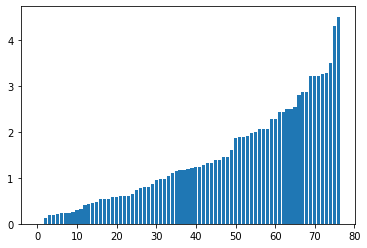

In [36]:
our_results["drivetimes"] =  (pd.to_datetime(our_results['Total Travel Time (h)'], format='%H:%M:%S').dt.hour + pd.to_datetime(our_results['Total Travel Time (h)'], format='%H:%M:%S').dt.minute/60).sort_values()
plt.bar(range(len(our_results["drivetimes"].to_list())),our_results["drivetimes"].sort_values().to_list())
print(len(our_results["drivetimes"].where(our_results["drivetimes"] < 1).dropna()))
print(len(our_results["drivetimes"].where(our_results["drivetimes"] > 1).dropna()))
print(our_results["drivetimes"].var())

In [9]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=(58.5476627, 13.9489607), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cyan", "black"]
type_colors=["black","red","green"]
numerical_route = get_numerical_path(plot_data_NSGAIII["paths"][0],vehicles)
for routeNumber,route in enumerate(numerical_route):

    routes = []
    
    for stop in route[::-1]:
        nodeType = 0
        if stop in startNodeIndeces:
            nodeType=2
        elif stop in endNodeIndeces:
            nodeType=1
        coordinates = (sigma_coordinates[stop%len(sigma_routing_context.distance_matrix)][0],sigma_coordinates[stop%len(sigma_routing_context.distance_matrix)][1])
        routes.append(coordinates)
        Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00')).add_to(folium_map)
  
    
    PolyLine(routes,color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map


In [339]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=(58.5476627, 13.9489607), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cyan","black"]
type_colors=["black","red","green"]
numerical_route = finished_sigma_routes
for routeNumber,route in enumerate(numerical_route):
    
    routes = []
    
    for stop in route:
        nodeType = 0
        if stop == route[0]:
            nodeType=2
        elif stop == route[-1]:
            nodeType=1
        coordinates = (sigma_coordinates[stop%len(sigma_routing_context.distance_matrix)][0],sigma_coordinates[stop%len(sigma_routing_context.distance_matrix)][1])
        routes.append(coordinates)
        Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00')).add_to(folium_map)
  
    
    
    
    
    
    PolyLine(routes,color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map


In [196]:
get_numerical_path(plot_data_NSGAIII["paths"][0],vehicles)

[[0, 26, 9, 10, 8, 33, 1, 15, 21],
 [23, 16, 17],
 [21, 12, 13, 11, 14],
 [24, 20, 2, 19, 3, 4, 17],
 [7, 6, 5, 17]]

In [197]:
finished_sigma_routes

[[33, 6, 5, 16, 3, 4, 18, 2, 19, 11, 17],
 [26, 12, 13, 14, 1, 15, 10, 9, 8, 17]]